# Unicornn - Spracherkennung mit Hilfe von Mel-Spektrogrammen

Lara Bertram (736057), Philipp Jonas Knohl (710050), Alexander Mikulaschek (736306), Alexander Pech (736825)

Dieses Notebook fokussiert sich auf die nähere Erläuterung zur Audiovorverarbeitung und Klassifikation der zugehörigen Beispielanwendung **Unicornn – Der intelligente Sprachassistent für Unity3D**, die im Rahmen des Moduls **Intelligente Systeme** entstanden ist und Sprachbefehle eines Nutzers in Aktionen innerhalb des Unity3D Editors verarbeitet.

<img src="https://github.com/Alpe6825/Unicornn/blob/master/Notebook/Bilder/Unicornn.png?raw=1">
<p style="text-align: center;">Abb. 1: Struktur des Projekts</p>



## Inhaltsverzeichnis

<a href="#Einleitung">1 Einleitung</a><br/>
<a href="#Audiovorverarbeitung">2 Audiovorverarbeitung</a><br/>
<a href="#Splitting-Audio">2.1 Splitting-Audio</a><br/>
<a href="#Zeitbereich-vs.-Frequenzbereich">2.2 Zeitbereich vs. Frequenzbereich</a><br/>
<a href="#Spektrogramme-&-Mel-Spektrogramme">2.3 Spektrogramme & Mel-Spektrogramme</a><br/>
<a href="#Interpretation-mit-CNN">3 Interpretation mit CNN</a><br/>
<a href="Interaktiver-Test">4 Interaktiver Test</a><br/>
<a href="#Quellenverzeichnis">Quellenverzeichnis</a><br/>


## Einleitung

Für die Analyse und Klassifikation von Audiodaten muss zunächst der Use Case definiert werden. Es besteht grundsätzlich die Wahl zwischen der Klassifikation einzelner Audiospuren/Audiofiles, die jeweils **diskrete und deterministische Inhalte** bereitstellen (z.B. ein einzelnes Wort, eine gesprochene Zahl, eine Farbe, etc.) oder von Inhalten in einem **kontinuierlichen Zusammenhang**, die als Einheit interpretiert werden sollen (z.B. "Alexa spiele Song 12 meiner Playlist").

Im Fall von Unicornn soll jeweils ein **Objekt** mit einer **Aktion** verbunden werden und als Eingabe dienen.

Zur Komplexitätsreduzierung und für die Möglichkeit, etablierte und gut beschriebene CNNs zur Klassifikation zu verwenden, wurde entschieden, die Interpretation einzelner diskreter Audioinhalte zu implementieren und dazu im Vorfeld an die eigentliche Klassifikation eine **Diskretisierung der Inputsequenzen** vorzunehmen. 

Die Trainingsdaten stammen aus dem [Speech Command Dataset v0.02](https://www.tensorflow.org/datasets/catalog/speech_commands) [5]. Dieser Datensatz enthält tausende von Aufnahmen einzelner Worte. Die verschiedenen Worte repräsentieren dabei die Klassen. Für unsere Anwendung sind lediglich die folgenden Worte/Aufnahmen der Klassen relevant:
„one“, „two“, „three“, „four“, „five“, „six“, „seven“, „eight“, „nine“, „forward“, „backward“, „left“, „right“, „up“ und „down“.


**Imports**
Für die, in diesem Notebook analysierte, Audio-Klassifikations-Anwendung werden folgende Pakete benötigt:
* Librosa für die Audioanalyse
* NumPy für die Handhabung mehrdimensionaler Arrays
* Soundfile zum Lesen und Schreiben von Audiodateien
* Matplotlib zur grafischen Darstellung
* PyTorch für die Erstellung des neuronalen Netzes
* IPython für Audioplayer
* ipywidgets für Buttons

In [1]:
!pip install librosa numpy soundfile matplotlib IPython ipywidgets

     |████████████████████████████████| 183 kB 2.7 MB/s eta 0:00:01
  Using cached SoundFile-0.10.3.post1-py2.py3.cp26.cp27.cp32.cp33.cp34.cp35.cp36.pp27.pp32.pp33-none-macosx_10_5_x86_64.macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.whl (613 kB)
     |████████████████████████████████| 786 kB 11.0 MB/s eta 0:00:01
  Using cached ipywidgets-7.5.1-py2.py3-none-any.whl (121 kB)
  Using cached audioread-2.1.8.tar.gz (21 kB)
     |████████████████████████████████| 300 kB 8.7 MB/s eta 0:00:01
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Using cached resampy-0.2.2.tar.gz (323 kB)
  Using cached numba-0.50.1-cp37-cp37m-macosx_10_14_x86_64.whl (2.1 MB)
     |████████████████████████████████| 45 kB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 175 kB 9.7 MB/s eta 0:00:01
  Using cached traitlets-4.3.3-py2.py3-none-any.whl (75 kB)
  Using cached backcall-0.2.0-py2.py3-none-any.whl (11 kB)
  Using cached appnope-0.1.0-py2.py3-none-any.whl (4.0 kB)
     |██

  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201375 sha256=b7f416f65cf50828b8a7e257aeca041df5627ab18e35125d7f5a726058533bb2
  Stored in directory: /Users/alexander/Library/Caches/pip/wheels/de/1e/aa/d91797ae7e1ce11853ee100bee9d1781ae9d750e7458c95afb
  Created wheel for audioread: filename=audioread-2.1.8-py3-none-any.whl size=23091 sha256=b29b08a7ae4b4f906ec7d4350118f507c405c598811226c5f4113ac4f6c4f744
  Stored in directory: /Users/alexander/Library/Caches/pip/wheels/cd/85/04/704a589ef8773d1ec1393c4b271a023f929d85ef5317b12d8c
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320718 sha256=44bde1ed572e56f1004f21e3dfce95e0ac734ba0f4016f8c14640aaf503ee44a
  Stored in directory: /Users/alexander/Library/Caches/pip/wheels/a0/18/0a/8ad18a597d8333a142c9789338a96a6208f1198d290ece356c
  Created wheel for tornado: filename=tornado-6.0.4-cp37-cp37m-macosx_10_9_x86_64.whl size=417089 sha256=2580a88c54dcbaee9a999a47524b3959fbbc4e3fedf7c1aeac716f5

In [2]:
#Für Windows: 
!pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 97.4 MB 12.5 MB/s eta 0:00:01
     |████████████████████████████████| 387 kB 10.5 MB/s eta 0:00:01
  Using cached Pillow-7.2.0-cp37-cp37m-macosx_10_10_x86_64.whl (2.2 MB)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
#Für Linux/Mac:
!pip install torch torchvision

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
!pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
from model.VGG import VGG
import IPython.display as ipd
import ipywidgets as widgets

## Audiovorverarbeitung

Bei Unicornn geht es um die Bewegung von Objekten. Zur Stuerung werden zwei Wörter benötigt. Das erste Wort dient zur Identifizierung des Objektes, das Zweite zur Beschreibung der Bewegung. Da unser Netz darauf trainiert wird einzelne Wörter zu klassifizieren, besteht der erste Schritt der Audioaufarbeitung darin, Aufnahmen in einzelne Wörter zu unterteilen.

**Beispielaufnahme:**

In [6]:
ipd.Audio('Audio/test.wav')

### Splitting Audio

Zur Aufteilung der Aunahme betrachten wir die Waveform bei der die Amplitude über die Zeit aufgezeigt wird.

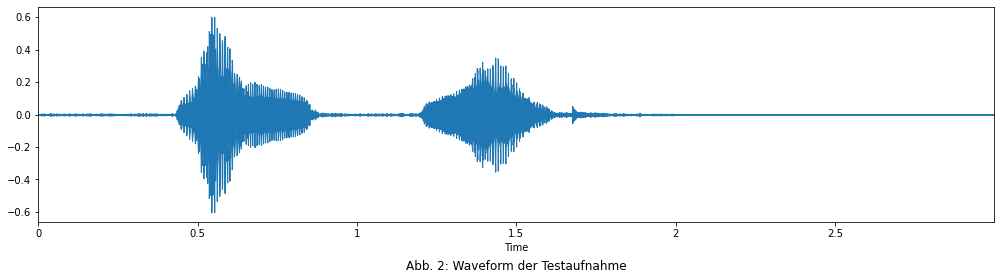

In [7]:
samples, sr = librosa.load('Audio/test.wav')
plt.figure(figsize=(14, 4))
plt.title("Abb. 2: Waveform der Testaufnahme", y=-0.25)
librosa.display.waveplot(samples, sr=sr)
plt.tight_layout()


Zur einfacheren Weiterverabreitung unterteilen wir die Waveform in kleinere Einheiten (genannt Buffer). Die Größe der Buffer wird durch die Variable bufferSize beschrieben. Bei einer Samplerate der Waveform von **16kHz** entspricht die Länge eines Buffers **64ms** (vgl. Formel 1). Eine häufig verwendete Buffergröße in der Audioverarbeitung beträgt 1024.

<br/>

\begin{equation}
Duration = \frac{BufferSize}{SampleRate} \qquad (1)
\end{equation}

In [8]:
bufferSize = 1024

Die Klasse **Buffer** speichert alle Samplewerte der Audiospur, die in der Länge des Buffers sind und die durchschnittliche Lautstärke des Buffers besitzen.

In [9]:
class Buffer:
    def __init__(self, values, loudness):
        self.value = values
        self.bufferLoudness = loudness

Die Funktion **HandeAudioBuffer** iteriert einmal durch die gesamte Audiospur und teilt diese in n Buffer auf.

In [10]:
def HandleAudioBuffer(samples):
    bufferCounter = 0
    bufferLoudness = 0
    allBuffers = []
    buffer = []

    for i in samples:
        if bufferCounter == 0:
            buffer = []

        if bufferCounter < bufferSize:
            bufferLoudness += abs(i)
            bufferCounter += 1
            buffer.append(i)

        if bufferCounter >= bufferSize:
            convertedBuffer = Buffer(buffer, bufferLoudness)
            allBuffers.append(convertedBuffer)
            bufferCounter = 0
            bufferLoudness = 0
    FindSeries(allBuffers)

Die Funktion **FindSeries** sucht eine Serie unter Buffern mit einer durchschnittlichen Lautstärke überhalb eines Thresholds, welche lang genug ist um als Wort zu gelten.

In [11]:
threshhold = 15

In [12]:
def FindSeries(buffers):
    foundSeries = False
    seriesCounter = 0

    series = []

    counter = 0
    for i in buffers:
        if CheckFutureBuffer(counter, buffers):
            foundSeries = True
            series.append(i)
        elif foundSeries:
            WrapUpSeries(counter, series, buffers, seriesCounter)
            foundSeries = False
            series = []
            seriesCounter += 1
        counter += 1

Die Funktion **CheckFutureBuffer** dient dazu die Lautstärke der zukünftigen Buffer zu überprüfen.

In [13]:
def CheckFutureBuffer(index, buffers):
    trueCounter = 0
    falseCounter = 0
    for i in range(index, index+25):
        if len(buffers) > i:
            if buffers[index].bufferLoudness > threshhold:
                trueCounter += 1
            else:
                falseCounter += 1

    if trueCounter > falseCounter:
        return True
    else:
        return False

Die Funktion **WrapUpSeries** fügt weitere Buffer mit der länge frontWrapperTimer bzw. endWrapperTimer vor und hinter der Serie an, damit die Worte nicht abgehackt wirken.

In [14]:
frontWrapperTimer = 0.1
endWrapperTimer = 0.1

In [15]:
def WrapUpSeries(index, series, buffers, seriesCounter):
    finalBuffering = []
    timeFactor = bufferSize / 48000
    startingPoint = index - len(series)

    frontWrapper = []
    counter = 0
    
    while counter * timeFactor < frontWrapperTimer:
        if(startingPoint - counter> 0):
            frontWrapper.append(buffers[startingPoint - counter - 1])
        counter += 1
        
    frontWrapper.reverse()

    for i in frontWrapper:
        finalBuffering.append(i)

    for i in series:
        finalBuffering.append(i)

    counter = 0
    while counter * timeFactor < endWrapperTimer:
        if(startingPoint - counter):
            finalBuffering.append(buffers[startingPoint + len(series) + counter + 1])
        counter += 1

    if seriesCounter == 0:
        firstWord = DeserializedSeries(finalBuffering, 1)
    elif seriesCounter == 1:
        secondWord = DeserializedSeries(finalBuffering, 2)

Die Funktion **DeserializedSeries** konvertiert die Buffer wieder zurück in Samplewerte und kreiert aus diesen ein Audiofile.

In [16]:
def DeserializedSeries(series, count):
    deSeries = []
    for i in series:
        for j in i.value:
            deSeries.append(j)
    if count == 1:
        sf.write('Audio/first.wav', deSeries, 22100, subtype='PCM_24')
        
    if count == 2:
        sf.write('Audio/second.wav', deSeries, 22100, subtype='PCM_24')
        
    return deSeries

#### Splitting der Beispielaufnahme:

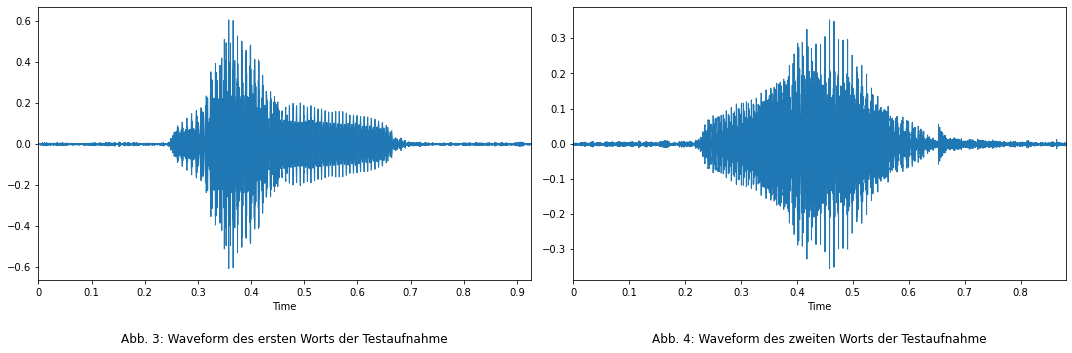

In [17]:
HandleAudioBuffer(samples)

plt.figure(figsize=(15, 5))

samples_firstword, sr = librosa.load('Audio/first.wav')
plt.subplot(121)
plt.title("Abb. 3: Waveform des ersten Worts der Testaufnahme", y=-0.25)
librosa.display.waveplot(samples_firstword, sr=sr)

samples_secondword, sr = librosa.load('Audio/second.wav')
plt.subplot(122)
plt.title("Abb. 4: Waveform des zweiten Worts der Testaufnahme", y=-0.25)
librosa.display.waveplot(samples_secondword, sr=sr)
plt.tight_layout()

**Audio der einzelnen Wörter:**

In [18]:
ipd.Audio('Audio/first.wav')

In [19]:
ipd.Audio('Audio/second.wav')

### Zeitbereich vs. Frequenzbereich

Für die **Supervised Classification** spielt die Darstellungsform der zu klassifizierenden Daten eine gesteigerte Rolle: bei der Klassifikation wird versucht **Patterns** aus den Eingangsdaten zu erlernen und später auf unbekannte Daten anzuwenden. Je geeigneter die Repräsentation zur Unterscheidung in möglichst vielen Anwendungsfällen gewählt wird, desto allgemeiner kann das System eingesetzt werden (z.B. in anderen Audioumgebungen)


#### Möglichkeit A:  Zeitbereich (Waveform)

Die einfachste Form der Audiorepräsentation findet sich in der sog. Waveform wieder. Hierbei ist die Amplitude der Audiosamples (z.B. 44100 Abtastwerte pro Sekunde bei einer Sampelrate von 44,1 kHz) über die Zeit aufgetragen. In der Dimension der **Zeitebene** kann leicht festgestellt werden wann Audioevents beginnen und enden – Aussagen über den konkreten Inhalt fallen auf visueller Basis schwer.

<img src="Bilder/Waveform.png">
<p style="text-align:center;">Abb. 5: Beispiel Waveform</p>


#### Möglichkeit B: Frequenzbereich (Spektrogramm)

Inhaltlich mehr Informationen lassen sich aus den enthaltenen Frequenzen einer Audiosequenz gewinnen. Statt eine wenig informative Aussage über Lautstärken zu diskreten Zeitpunkten zu erhalten können auf der **Frequenzebene** genaue Informationen über variierende Inhalte der Audiosequenzen getroffen werden. Genau wie verschiedene Worte unterschiedliche Buchstaben enthalten, enthalten dise später auch verschiedene Frequenzbereiche, die durch die jeweilige Aussprache entstehen. Durch eine mittlerweile etablierte **Fast Fourier Transformation** können die 2D-Informationen (x: Zeit & y: Amplitude) aus dem Zeitbereich in eine 3D-Information **transformiert** werden (x: Zeit & y: Frequenz & z: Intensität (meist in dB)).

Hierdurch eignen sich Spektrogramme besonders gut als Input für **Convolutional Neural Networks**, die sowohl in der Zeitachse als auch der Frequenzachse nach **Patterns** suchen können.

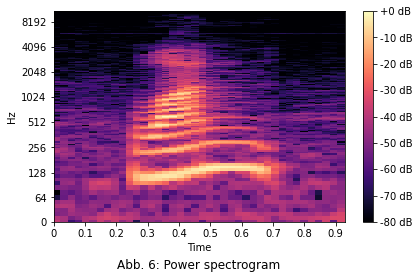

In [20]:
y, sr = librosa.load("Audio/first.wav")
D = librosa.stft(y)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title("Abb. 6: Power spectrogram", y=-0.25)
plt.tight_layout()

### Spektrogramme & Mel-Spektrogramme


Das menschliche Gehör verhält sich oft nicht linear. Angefangen bei der Wahrnehmung von Lautstärke bzw. Lautheit, bis hin zur  Wahrnehmung von Tonhöhen. Diesen Umstand kann man sich zu Nutze machen und die relevanten Frequenzbereiche aus den klassischen Spektrogrammen weiter einschränken, indem eine weitere **Filterung** mit einer Reihe von Bandpassfiltern durchgeführt wird, die einzelne Frequenzbänder nach ihrere Relevanz zur inhaltlichen Unterscheidung verändern (vgl. Formel 2 und Abb. 7).

\begin{equation}
M(f) = 2595 * log(1 + f / 700) \qquad (2)
\end{equation}

<img src="Bilder/Mel-Values.png" style="height: 400px;text-align: center;">
<p style="text-align: center;clear:left;">Abb. 7: Mel-Werte nach Formel 2 [3]</p>

Aus einem umfangreichen Spektrogramm können somit sog. "mel bins" extrahiert werden (Einheit: mel statt Hertz), die die wesentlichen und relevanten Informationen in der **Frequenzebene** enthalten.

Librosa teilt die bins dabei bis 1000 Hz nach linearem Abstand auf (im Sinne der akkustischen Wahrnehmung, nicht der Fequenzwerte) und anschließend logarithmisch. Dieser Umstand resultiert aus dem Verhalten des menschlichen Gehörs, das in den unteren und mittleren Frequenzbereichen auch kleinere Abweichungen deutlicher wahrnehmen kann als in den oberen Frequenzbereichen (siehe auch Mel Filterbank).

<img src="Bilder/Mel-Filterbank.png?" style="height: 400px;text-align: center;">
<p style="text-align: center;clear:left;">Abb. 8: Mel-Filterbank [3]</p>

#### Convert to Image
Die Funktion **wave2image** konvertiert eine .wav-Datei zu einem Mel-Spektrogramm in Form eines Arrays. Wir verwenden für die Berechnung des Mel-Spektrogramms 32-Filterbänke, was zu einer vertikalen Bildausfösung von 32 Pixeln führt. Für das Model haben wir eine Input Auflösung von 32x32 Pixeln festgelegt. Um im Zeitbereich eine konstante Auflösung zu erzeugen wird die Länder der Audioaufnahme auf eine Sekunde beschränken bzw. erweitern.

In [21]:
durationOfAudioSample = 1

def wave2image(file):

    samples, sample_rate = librosa.core.load(file,sr=16000)

    # correct length of audiosample to fix length
    fixed_sample_length = int(durationOfAudioSample * sample_rate)
    if fixed_sample_length < len(samples):      #truncate
        samples = samples[:fixed_sample_length]
    elif fixed_sample_length > len(samples):    # add silence
        samples = np.pad(samples, (0, fixed_sample_length - len(samples)), "constant")

    # Create Mel-Spectrum
    s = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=32)
    mel = librosa.power_to_db(s, ref=np.max)
    return mel

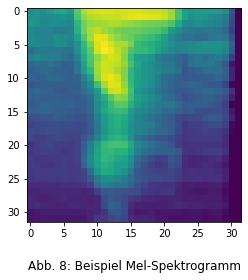

In [22]:
plt.imshow(wave2image("Audio/first.wav"))
plt.title("Abb. 8: Beispiel Mel-Spektrogramm", y=-0.25)
plt.tight_layout()

#### Geplottete Audiospuren
Zur Veranschaulichung werden hier einmal verschiedene Mel-Spektrogramme aller Klassen dargestellt (vgl. Abb. 9).


<table style="float:left">
    <tr>
        <th style="text-align:center">Zero</th>
        <th style="text-align:center">One</th>
        <th style="text-align:center">Two</th>
        <th style="text-align:center">Three</th>
        <th style="text-align:center">For</th>
        <th style="text-align:center">Five</th>
        <th style="text-align:center">Six</th>
        <th style="text-align:center">Seven</th>
        <th style="text-align:center">Eight</th>
        <th style="text-align:center">Nine</th>
    </tr>
    <tr>
        <td><img src="Bilder/Mel-Spektrogramme/0.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/1.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/2.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/3.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/4.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/5.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/6.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/7.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/8.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/9.png"/></td>
    </tr>
</table>

<table style="float:left">
    <tr>
        <th style="text-align:center">Forward</th>
        <th style="text-align:center">Backward</th>
        <th style="text-align:center">Left</th>
        <th style="text-align:center">Right</th>
        <th style="text-align:center">Up</th>
        <th style="text-align:center">Down</th>
    </tr>
    <tr>
        <td><img src="Bilder/Mel-Spektrogramme/10.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/11.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/12.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/13.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/14.png"/></td>
        <td><img src="Bilder/Mel-Spektrogramme/15.png"/></td>
    </tr>
</table>
<p style="clear:left; text-align:center;">Abb. 9: Beispiel Mel-Spektrogramme aller Klassen</p>

## Interpretation mit CNN

<img src="Bilder/CNN_Schema.jpg" />
<p style="clear:left; text-align:center;">Abb. 10: Beispiel CNN-Schema (basierend auf [1])</p>

In dem Projekt **Unicornn - Der intelligente Sprachassistent für Unity3D** wurde der Agent mit zwei verschiedenen CNNs (VGG19 [4] und ResNet [2]) in Kombination mit zwei Optimierern (Adam und SGD) trainiert (vgl. [train.ipynb](https://github.com/Alpe6825/Unicornn/blob/master/train.ipynb) bzw. [Ausarbeitung](https://github.com/Alpe6825/Unicornn/blob/master/Docu/Doku%20Abgabe/Unicornn.pdf)). Da hier die Verwendung eines VGG19-Netzes mit dem Adam-Optimierer zu den besten Ergebnissen geführt hat, wird dieses im Folgenden näher erläutert.

CNNs dienen dazu charakteristische Features innerhalb des Bildes zu erkennen (Feature-Erkennung) und anschließend einer Klasse zuzuordnen (Klassifizierung) (vgl. Abb. 10).

Über die Zuweisung self.features = nn.Sequential(...) werden dem Modell eine Vielzahl an Schichten hinzugefügt. Dabei ist zu erkennen, dass eine gewisse Abfolge von aufeinanderfolgenden Schichten immer wieder auftaucht.

    nn.Conv2d(..., ..., kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(..., eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv2d(..., ..., kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(..., eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    (nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),)

Durch die Funktion Conv2(...) wird eine 2D-Faltungsschicht erzeugt. Diese Schicht dient dazu erlernte Merkmale mit Eingabedaten zu falten und somit Übereinstimmungen festzustellen. Dabei werden die Anzahl der Input- und Output-Channels, die Kernel-Size (Größe des "Fensters" für die Faltung), die Stride (Schrittweite) für die Kreuzkorrelation und die Anzahl der mit Null aufgefüllten Zeilen für jede Schicht dieser Art festgelegt. 

In diesem Fall werden die Graustufenwerte der Mel-Spektrogramm-Darstellung in das Netz gegeben und zu Beginn durch Faltung mit 64 erlernten Merkmalen analysiert. Die daraus entstehenden Output-Werte werden nach einer Batch-Normalisierung und Aktivierung mittels ReLU-Funktion (inplace=True: Veränderungen werden direkt auf die Werte des Arrays angewendet, ohne vorher eine Kopie zu erstellen) in die nächste Faltungsschicht gegeben. Durch diese aufeinanderfolgenden Faltungen wird das Bild weitergehend analysiert. An einigen Stellen, wird nach der Aktivierungsschicht zur Reduzierung der Auflösung der Featuremaps der Maxpooling Algorithmus mit einer Kernelgröße von 2x2 verwendet.

Zum Schluss der Feature-Erkennung liegen 512 Output-Channels vor, die mithilfe der Funktion flatten(x,start_dim=1) geglättet werden, bevor sie in den Klassifizierer gegeben werden. Dort erfolgen drei lineare Transformationen, die die Input-Channels schlussendlich auf die Klassen, also die verschiedenen Wörter, abbilden.

In [23]:
model = VGG(16)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Interaktiver Test

Zur Demonstration können die Wörter der oben bereits gezeigten Beispielaufnahme hier Klassifiziert werden. Zur Klassifizierung wird das VGG[4] verwendet, welches wir mit dem Adam Optimizer und dem SpeechCommand v0.02 Datensatz [5] trainiert haben. **Viel Spaß!**

In [24]:
model.load_state_dict(torch.load("model/bestWeights_VGG_Adam.pth", map_location=torch.device('cpu')))
model.eval()

classes = {
    "0": "Zero",
    "1": "One",
    "2": "Two",
    "3": "Three",
    "4": "Four",
    "5": "Five",
    "6": "Six",
    "7": "Seven",
    "8": "Eight",
    "9": "Nine",
    "10": "Forward",
    "11": "Backward",
    "12": "Left",
    "13": "Right",
    "14": "Up",
    "15": "Down",
}


def foreward_model(path):
    
    _image = wave2image(path)
    # scale to Range[0;1]
    _min = np.min(_image)
    _image -= _min
    _max = np.max(_image)
    _image /=_max

    inputTensor = torch.Tensor(_image).unsqueeze(0).unsqueeze(0)
    output = model(inputTensor).argmax(1).item()

    return classes.get(str(output))


In [25]:
print ("Welches Wort möchten Sie durch das Netz schicken?")
button1 = widgets.Button(description='First Word')
button2 = widgets.Button(description='Second Word')
out = widgets.Output()

def on_button1_clicked(_):
    with out:
        print(foreward_model("Audio/first.wav"))
def on_button2_clicked(_):
    with out:
        print(foreward_model("Audio/second.wav"))
        
button1.on_click(on_button1_clicked)
button2.on_click(on_button2_clicked)

widgets.HBox([button1,button2,out])

Welches Wort möchten Sie durch das Netz schicken?


Zur Überprüfung die Beispielaufnahme:

In [26]:
ipd.Audio('Audio/test.wav')

## Quellen

[1] Yung-Hsiang Shawn Chang, Yuan-fu Liao, Sheng-Ming Wang, Jenq-Haur Wang, Sing-yue Wang, Jhih-wei Chen, You-dian Chen. 2017. Development of a Large-Scale Mandarin Radio Speech Corpus. Proceedings of the IEEE International Conference on Consumer Electronics-Taiwan.

[2] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. 2015. Deep Residual Learning for Image Recognition. arXiv:1512.03385 [cs.CV]

[3] Linus Lexfors and Malte Johansson. 2018. "Audio representation for environmental sound classification using convolutional neural networks" http://lup.lub.lu.se/student-papers/record/8964345

[4] Karen Simonyan and Andrew Zisserman. 2014. Very Deep Convolutional Networks
for Large-Scale Image Recognition. arXiv:1409.1556 [cs.CV]

[5] Pete Warden. 2018. Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition. ArXiv e-prints (April 2018). arXiv:1804.03209 [cs.CL] https://arxiv.org/abs/1804.03209